In [1]:
import NCDatasets
import Plots
import Flux
import Statistics
import Distributions

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [2]:
# preparing training data

#fn_qv = "../LES_data/data/training_data/qv.x0.0.nc"
#fn_mu = "../LES_data/data/training_data/cvrxp_p_stddivs.x0.0.nc"

fn_qv = "../LES_data/data/noshear_br0.05.tn6/rico.qv.nc"

da_qv = NCDatasets.Dataset(fn_qv)
#da_mu = NCDatasets.Dataset(fn_mu)

zslice = 1:40
#xslice = nothing
#yslice = nothing
x_grid = da_qv["xt"]#[xslice]
y_grid = da_qv["yt"]#[yslice]
z_grid = da_qv["zt"][zslice]
qv = Float32.(replace(da_qv["qv"][zslice,:,:,1], missing => 0.0))

qv_mean = Statistics.mean(qv)
qv_std = Statistics.std(qv)
qv .-= qv_mean
qv ./= qv_std

0

0

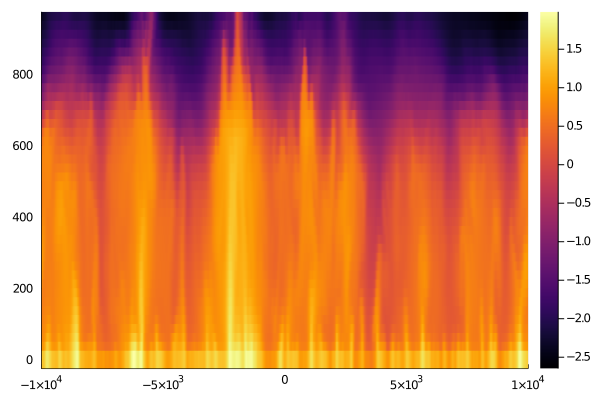

In [3]:
Plots.heatmap(x_grid, z_grid, qv[:,:,1])

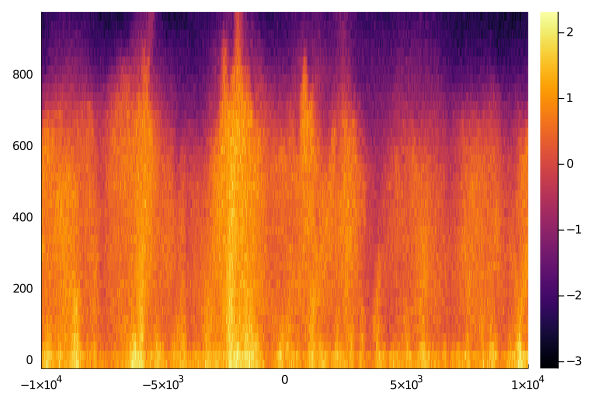

In [4]:
function add_noise(x; σ=0.01)
    dist =  Distributions.Normal(0.0, σ)
    x + (typeof(x))(rand(dist))
end

Plots.heatmap(x_grid, z_grid, add_noise.(qv[:,:,1]; σ=0.2))

In [5]:
function make_model_1()
    Nf = 5
    Nc = 6 # num channels

    # ╔═╡ 1cbd694c-6ae6-11eb-26bd-136c79a123c3
    model = Flux.Chain(
            # reshape to add channels and batch dimensions
            x -> reshape(x, size(x, 1), size(x, 2), 1, size(x, 3)),

            ## NN interior below
            # first convolution
            Flux.Conv((Nf, Nf), 1 => Nc, Flux.sigmoid),
            #Flux.MaxPool((4,4)),
            Flux.Conv((Nf, Nf), Nc => Nc, Flux.sigmoid),
            Flux.Conv((Nf, Nf), Nc => 1, Flux.sigmoid),
            #x -> reshape(x, :), # flatten
            #Flux.Dense(Nd*Nd, 1)
            #Flux.Conv((Nd, Nd), 1 => 1),
            #x -> Flux.Conv((size(x, 1), size(x, 2)), 1 => 1)(x),

            # flatten, remove channels and batch dimensions
            x -> reshape(x, size(x, 1), size(x, 2), size(x,4)), 
    )
    return model
end
model = make_model_1()

Chain(#2, Conv((5, 5), 1=>6, σ), Conv((5, 5), 6=>6, σ), Conv((5, 5), 6=>1, σ), #3)

Every training example consists of:

- `y` a slice at along the x or y direction at a random location offset by a random amount
- `x` as `y` but with added noise

These need to be grouped into batches. 

In [6]:
struct DataLoaderLES{D}
    data::AbstractArray{D,3}
    batchsize::Int
    nbatches::Int
end

function DataLoaderLES(data; batchsize=100, nbatches=1)
    batchsize > 0 || throw(ArgumentError("Need positive batchsize"))
    nbatches > 0 || throw(ArgumentError("Need positive nbatches"))

    DataLoaderLES(data, batchsize, nbatches)
end

function _getSlice(data::AbstractArray{D,3}, i::Int) where D
    # TODO: add noise and random offset here
    #@show size(data[:,i,:])
    data[:,i,:]
end

# required functions to support iteration
Base.length(dl::DataLoaderLES) = dl.batchsize * dl.nbatches


function Base.iterate(d::DataLoaderLES, i=0; σ_noise=0.5)
    if i >= d.nbatches
        return nothing
    end
      
    y_source = cat([_getSlice(d.data, idx) for idx in 1:d.batchsize]...; dims=3)
    # In predicition the convolutions mean we can't predict the edge
    y_batch = y_source[6:end-7,6:end-7,:]
    # TODO: add noise to y_batch
    x_batch = add_noise.(y_source; σ=σ_noise)
        
    batch = (x_batch, y_batch)
    return (batch, i+1)
end

dl = DataLoaderLES(qv; nbatches=2, batchsize=4)
@show dl.batchsize dl.nbatches

for (x, y) in dl
    ŷ = model(x)
    @show size(x) size(y) size(ŷ)
    @show Flux.Losses.mse(ŷ, y)
end

dl.batchsize = 4
dl.nbatches = 2
size(x) = (40, 800, 4)
size(y) = (28, 788, 4)
size(ŷ) = (28, 788, 4)
Flux.Losses.mse(ŷ, y) = 0.3678708f0
size(x) = (40, 800, 4)
size(y) = (28, 788, 4)
size(ŷ) = (28, 788, 4)
Flux.Losses.mse(ŷ, y) = 0.36790717f0


In [7]:
training_set = DataLoaderLES(qv; nbatches=2, batchsize=4)
m = make_model_1()
loss1(x, y) = Flux.Losses.mse(model(x), y)

for d in training_set # assuming d looks like (data, labels)
    @show d[1] d[2]
    # our super logic
    gs = Flux.gradient(Flux.params(m)) do #m is our model
      l = loss1(d...)
    end
    Flux.update!(opt, Flux.params(m), gs)
end

d[1] = Float32[0.78432286 1.6039102 0.37380195 1.4154935 1.2377338 1.3031882 1.33055 0.52348226 1.8189178 1.4479723 2.9548001 0.6927676 1.4291688 2.5419354 1.6887615 1.718552 1.8223655 1.00672 1.5588468 0.7040988 1.1672133 1.2680827 1.1446791 1.6324356 1.238277 1.3094419 1.3948697 1.4350657 0.8886522 1.5639155 2.6366544 1.22935 1.4896588 1.9438701 1.7784221 1.5163568 2.2382512 1.7248673 1.4877309 1.4319125 1.4924208 0.7946327 0.033571005 1.2493377 1.8332354 1.2639695 1.2232682 1.4892071 1.1371675 1.1266677 1.3823946 1.7110902 1.0530648 1.3830061 1.48473 1.8044621 1.7604477 1.758189 1.5395637 1.2079592 1.3171395 1.5826396 1.6885443 2.0030158 2.2977886 1.1231346 1.804868 1.1270592 1.2479334 1.133899 1.1041608 2.2181294 0.67469424 1.9121132 0.9319395 1.3580095 1.6380945 2.9687958 2.0507212 1.4442251 0.3362751 0.9086511 2.0984583 1.1886746 0.7849995 0.99145883 0.7651217 1.4765242 0.9182057 2.0269916 0.627083 1.7494934 1.3135219 2.295543 1.3053995 0.1775713 1.6238866 2.1043632 1.0958941 1.8

 1.1712579 0.55518174 0.62019 0.6398861 1.1504737 1.4271042 0.8425498 1.3069422 0.394567 -0.33093917 0.9551588 0.5934904 1.0981293 0.2880084 0.0012251437 1.4422214 0.46133453 0.49851787 -0.6365108 -0.3995249 -0.10366899 -0.2883319 0.07119187 0.32247722 0.49648643 -0.56464887 0.4846935 -0.49744326 0.07773313 0.4967771 -0.56694967 -0.12745494 -0.62973166 -0.70637095 0.72157 -0.77676153 -0.07586682 0.95375913 -0.0034701787 0.47388393 -0.6676155 0.021884028 0.94825894 -0.016153766 -0.46763113 0.46567777 0.61847067 -0.29262975 0.21787715 0.17893665 0.7610995 0.17108457 -0.15355317 -0.21802671 -0.64758897 -0.61380094 -0.480423 0.12228608 -0.58914673 0.24283525 0.46212274 -1.0418868 1.1976161 0.5153805 -0.5797132 -0.9060448 0.7369517 -0.30964682 -0.030304 0.26932085 0.43992195 0.8273448 0.5903009 0.108519584 -0.27356282 -0.5012346 -0.0784668 -0.35451826 1.2882122 0.36012527 0.39218202 0.064925194 0.531157 1.3006319 -0.3714939 1.060773 0.8744463 0.8852587 0.6645836 0.15250224 1.134604 0.441440

45 0.66126245 0.47000208 0.7179116 0.14264059 0.5171699 0.81036615 0.85051024 1.157387 0.34693182 0.6554542 1.2161518 0.8168689 0.238979 1.0467594 1.0627038 -0.38306427 0.78345895 -0.5952438 0.9863725 0.48089775 0.049960285 0.32982576 0.2607543 1.253574 0.23353408 0.46356308 1.0535761 -0.28369614 -0.15580763 -0.020359129 0.16230199 -0.05707857 0.106318906 0.011774272 0.24945793 0.16853262 0.6378758 0.116730094 0.29539955 0.71336216 -0.7067783 0.16586125 0.23815697 0.14310282 0.1818887 0.4336009 0.059346944 -0.22412792 -0.017340451 -0.31434745 -0.23714456 1.1672865 0.54230434 1.1392207 0.41097564 -0.6917058 -0.13898224 0.14717871 -0.4881701 1.2812928 0.05599898 0.30310547 0.45156106 1.1367424 -1.1100491 0.7945055 0.05732006 0.40602764 -0.1296615 0.46245933 1.7067621 0.894137 0.46973282 0.28938338 0.18756866 1.3887775 1.3356807 0.47585073 1.6410425 1.6052895 0.42339274 0.115097165 1.4633499 0.2676664 1.3824445 1.1453694 1.1849643 0.5792369 1.119396 1.1285998 1.1517378 0.8580447 1.480208 

503375 -1.280247 0.01865691 -1.095082 -0.4948936 0.4842588 0.36177912 -0.69420373 -0.45752615 -0.18944265 0.15780905 0.30798453 -0.54494226 0.17528269 -0.07887612 -0.29415676 -0.7618413 0.7447196 0.24855533 0.6885879 -0.04919991 0.99873817 0.07712746 0.36380115 1.0433462 0.2295314 1.2741988 1.4358346 0.90182996 1.3572979 1.2535951 0.3400727 0.9883734 -0.16171849 0.96874547 0.52835846 0.81807804 1.13338 1.138808 0.38548008 0.100587934 0.10801366 -0.062341332 -0.40611157 1.2425455 0.4584029 0.8644023 -0.064581156 0.47044498 -0.40496477 0.6799569 0.9991355 0.054429054 0.5970087 0.61136246 0.7502678 1.0939413 0.1396515 0.9778879 1.0716643 0.6600034 -0.057132244 0.037426084 0.34111983 0.29101002 0.31437635 0.6214813 0.4763026 -0.17930588 -0.11833322 0.48178685 0.85807097 0.7567568 -0.074505985 0.2343881 -0.6470422 0.5854156 0.00066035986 -0.2783724 -0.86977744 0.8076085 0.7212323 0.5134312 0.19603322 0.7090018 -0.25620702 0.92435944 -0.0662556 0.2295046 0.61390287 -0.6021277 1.3741305 1.127

85097 -0.276613 -0.7982207 -1.0541351 0.5346408 0.5269794 0.23063053 0.76534003 1.0900251 -0.17251563 0.7730516 0.50864375 0.88107115 0.24535218 -0.45758247 0.18939465 -0.24149638 -0.29763085 -0.799261 0.1866598 0.04010275 0.09649862 -0.74186444 -0.19159515 0.0032838285 0.07152867 -1.0994375 0.32793424 0.45228454 -0.6667788 -0.77356017 -0.16319594 -0.694872 -0.79777616 -1.009069 -0.49732175 -0.66274554 -0.4969488 -0.49511474 -0.51598734 -0.7743888 -0.63777405 -0.1700556 -0.43550313 -0.84605044 -0.95352167 -1.1494765 -1.4227176 -1.0370584 -0.56159765 -1.4588941 -0.7533512 -0.3392672 -0.8589196 -1.6143196 -0.68163204 -0.27187586 -0.71444404 -1.2470702 -0.2111871 -0.048021257 -1.046837 -0.50865024 -0.41149953 -1.009107 -0.2000319 -1.0395199 -0.014981687 -0.72150105 0.51043063 -1.3809892 -1.4589925 -0.87793756 -1.6377258 -0.640091 -0.23345092 -0.61423415 -1.0170703 -0.5833861 -0.83329993 -0.38631275 -0.6294892 -0.5069465 0.2067006 -0.77518064 -0.3191372 0.3122061 -0.5465052 0.12262562 0.35

1.9251916 -0.72522396 -1.7792457 -1.2748973 -2.3106768 -1.9903355 -1.3510609 -1.5493686 -1.7524655 -1.6196531 -1.6473655 -1.6497059 -1.8194427 -1.6582885 -0.8778587 -1.1038072 -1.4828931 -1.4417439 -0.5490352 -1.5167263 -1.7554668 -1.5990593 -2.4961512 -2.3208363 -2.2183118 -1.6444681 -1.264854 -1.1786687 -1.6556076 -2.3419166 -2.120772 -1.7696811 -2.9109087 -1.8406882 -1.8536931 -2.4091353 -1.5742993 -1.8622912 -2.0860584 -2.2418094 -1.6184504 -2.4459667 -0.94960356 -2.3491275 -2.0772324 -2.513488 -3.0426764 -2.7661507 -2.10413 -1.849035 -2.911135 -2.8935888 -3.1582336 -2.6886764 -2.5287812 -2.1298246 -3.3145323 -2.816974 -2.2688801 -2.1663227 -2.9287863 -2.6525025 -3.3234034 -2.2015722 -3.3987083 -1.8163357 -3.1418662 -1.2150334 -2.9769497 -1.8220552 -3.984946 -2.2265625 -3.738154 -1.430232 -1.8884554 -2.6404712 -2.7879426 -2.1958704 -1.9046488 -2.5441015 -2.949997 -2.5723262 -2.500398 -2.7651398 -2.4696813 -1.8098862 -1.5806863 -3.2094865 -2.0855339 -2.3629484 -2.7948 -1.9503478 -1.

Float32[1.4950943 1.782219 1.7819183 1.2343128 1.2394102 1.6596338 1.098849 0.4697566 1.2875725 1.0571865 0.95510936 1.5388436 1.5299364 1.083167 1.5136905 1.7673533 1.5371615 1.4204941 1.5248969 1.836817 1.1680778 0.9742718 1.4582037 1.4544637 1.4182587 0.7027654 1.635968 2.7010496 1.1251442 1.4326966 2.1748703 1.4690909 1.3171755 0.89828956 1.5906065 1.6368854 1.6480918 1.5562811 1.3404841 1.0653788 1.2615947 1.3616811 0.97622937 1.0641727 0.4845307 2.5310783 0.8873732 1.5974696 1.5632613 1.6223404 1.1510468 1.4646719 2.5292187 0.08263743 1.7486352 1.619369 2.5976815 0.7807195 1.3788801 2.0965 2.1363761 1.2921418 1.0782126 2.2044559 0.77784115 1.8716595 1.2251931 2.136151 1.5732051 1.7403564 0.7997127 0.7451954 2.5765371 2.2003632 1.0038632 3.069284 1.1840591 2.0831325 1.9159927 1.2741524 1.4684772 1.1803547 2.0727766 0.7431561 1.4755156 0.66345334 1.7420375 0.5774176 1.1995788 1.0669394 0.26583755 1.064601 1.3089215 1.435654 1.5311596 1.9219645 1.3139946 2.010332 2.2216291 2.712187 

Excessive output truncated after 524295 bytes.

LoadError: UndefVarError: opt not defined

In [8]:
function denorm(v)
    (v*qv_std) + qv_mean
end

denorm (generic function with 1 method)

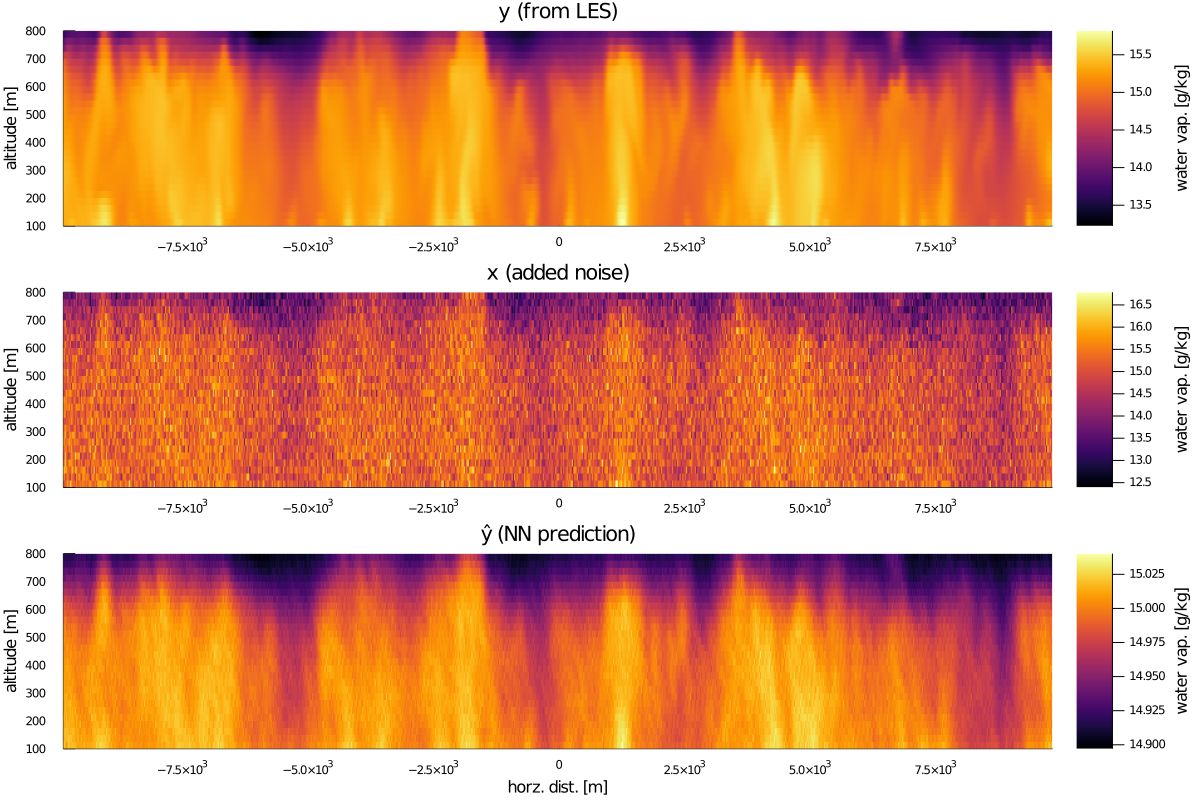

In [18]:
function plot_pred(x, y, ŷ)
    #z_grid = da_qv["zt"][6:end-7]
    #x_grid = da_qv["xt"][6:end-7]
    x_grid_conv = x_grid[6:end-7]
    z_grid_conv = z_grid[6:end-7]

    p1 = Plots.heatmap(x_grid_conv, z_grid_conv, denorm.(y), title="y (from LES)", ylabel="altitude [m]", colorbar_title="water vap. [g/kg]")
    p2 = Plots.heatmap(x_grid_conv, z_grid_conv, denorm.(x[6:end-7,6:end-7]), title="x (added noise)", ylabel="altitude [m]", colorbar_title="water vap. [g/kg]")
    p3 = Plots.heatmap(x_grid_conv, z_grid_conv, denorm.(ŷ), title="ŷ (NN prediction)", ylabel="altitude [m]", xlabel="horz. dist. [m]", colorbar_title="water vap. [g/kg]")

    Plots.plot(p1, p2, p3, layout=(3,1); size=(1200, 800))
end

x, y = collect(DataLoaderLES(qv; nbatches=1, batchsize=1))[1]
x1 = x[:,:,1]
y1 = y[:,:,1]
ŷ1 = model(x)[:,:,1]
plot_pred(x1, y1, ŷ1)

In [16]:
opt = Flux.Optimise.Descent(0.5)
lossfn1(x, y) = Flux.Losses.mse(model(x), y)
test_x, test_y = collect(DataLoaderLES(qv; nbatches=1, batchsize=1))[1]

evalcb() = @show(lossfn1(test_x, test_y))

Flux.@epochs 4 Flux.train!(lossfn1, Flux.params(model), DataLoaderLES(qv; batchsize=50), opt; cb=Flux.throttle(evalcb, 10))

#x1, y1 = _getExample(qv)
#plot_pred(x1, y1, model(x1))

┌ Info: Epoch 1
└ @ Main /nfs/see-fs-02_users/earlcd/.julia/packages/Flux/sY3yx/src/optimise/train.jl:136


lossfn1(test_x, test_y) = 0.34235242f0


┌ Info: Epoch 2
└ @ Main /nfs/see-fs-02_users/earlcd/.julia/packages/Flux/sY3yx/src/optimise/train.jl:136


lossfn1(test_x, test_y) = 0.33440167f0


┌ Info: Epoch 3
└ @ Main /nfs/see-fs-02_users/earlcd/.julia/packages/Flux/sY3yx/src/optimise/train.jl:136


lossfn1(test_x, test_y) = 0.3265181f0


┌ Info: Epoch 4
└ @ Main /nfs/see-fs-02_users/earlcd/.julia/packages/Flux/sY3yx/src/optimise/train.jl:136


lossfn1(test_x, test_y) = 0.3137535f0


In [19]:
x, y = collect(DataLoaderLES(qv; nbatches=1, batchsize=1))[1]
x1 = x[:,:,1]
y1 = y[:,:,1]
ŷ1 = model(x)[:,:,1]
plot_pred(x1, y1, ŷ1)
Plots.savefig("NN_qv_denoise_example.png")

In [12]:
b = rand(4, 3, 2)
size(b)

(4, 3, 2)

In [13]:
size(b[1,:,:])

(3, 2)

In [14]:
hcat([b[i,:,:] for i in 1:3]...)

3×6 Array{Float64,2}:
 0.999782   0.315371  0.901769  0.261342  0.0766818  0.106314
 0.141556   0.715692  0.107084  0.138751  0.765386   0.188851
 0.0432148  0.373566  0.282576  0.303369  0.0896214  0.230544